# **Data exploration and manipulation**

![picture](https://drive.google.com/uc?id=1GbpFHyG8acDZBP1ugInjjfyGGoS5znXS)
### This notebook analyzes and manages the data collected from the [shotcafe](https://shot.cafe) database made available to us by its owner. The notebook is divided into several sections, each of which relates to one of the proposed tasks.
> *   ### Shot type classification
> *   ### Shot ambient classification
> *   ### Color palette clustering
### For each of these tasks it is described how the data was managed, and how the datasets were created.

# **0. Spark + Google Colab Setup**

## **0.1** Define global variables

In [1]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/drive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "<path>"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "<path>"
GDRIVE_DATA_CSV = GDRIVE_HOME_DIR + "<path>"
GDRIVE_CLUSTER_DATA_DIR = GDRIVE_HOME_DIR + "<path>"

RANDOM_SEED = 42 # for reproducibility

## **0.2** Install PySpark and related dependencies

In [2]:
!pip install pyspark
# Alternatively, if you want to install a specific version of pyspark:
#!pip install pyspark==3.2.1
!pip install -U -q PyDrive # To use files that are stored in Google Drive directly (e.g., without downloading them from an external URL)
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=5aa966b5aacdd81dce77e593c3bcc9994f94715bde247147b9fda8fca3a7609c
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:a

## **0.3** Import useful Python packages

In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

## **0.4** Create Spark context

In [4]:
# Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '4G').\
                set('spark.driver.memory', '45G').\
                set('spark.driver.maxResultSize', '10G').\
                setAppName("shotcafeDataExploration").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

# **1. Link Colab to our Google Drive**

In [5]:
# Point Colaboratory to our Google Drive
from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


# **2. Data Acquisition**

In [6]:
#The csv file containing the main information of the shotcafe is loaded into a SparkDataframe
shotcafe_df = spark.read \
            .format("csv") \
            .option("header", "true") \
            .load(GDRIVE_DATA_CSV) \
            .drop("_c0")

In [ ]:
shotcafe_df.printSchema()

root
 |-- image: string (nullable = true)
 |-- movie_title: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- shot_type: string (nullable = true)
 |-- ambient: string (nullable = true)



In [ ]:
shotcafe_df.show(truncate=False)

+-----+---------------------+-----------------------------------+------------+--------+
|image|movie_title          |filename                           |shot_type   |ambient |
+-----+---------------------+-----------------------------------+------------+--------+
|16587|1917                 |1917-2019-260-16587.jpg            |medium shot |exterior|
|16589|1917                 |1917-2019-260-16589.jpg            |extreme wide|exterior|
|16591|1917                 |1917-2019-260-16591.jpg            |wide shot   |exterior|
|16592|1917                 |1917-2019-260-16592.jpg            |medium wide |exterior|
|16593|1917                 |1917-2019-260-16593.jpg            |medium wide |exterior|
|16594|1917                 |1917-2019-260-16594.jpg            |medium shot |exterior|
|16596|1917                 |1917-2019-260-16596.jpg            |medium wide |interior|
|16597|1917                 |1917-2019-260-16597.jpg            |null        |interior|
|16598|1917                 |191

### Check the shape of the loaded dataset, i.e., number of rows and columns

In [ ]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(shotcafe_df.count(), len(shotcafe_df.columns)))

The shape of the dataset is 15696 rows by 6 columns


# **3. Datasets creations and exploration by task**


## **3.1** Shot type


### In this section, the dataset relating to the classification task of the different types of shots is created:

*  ### Close-up
*  ### Medium Close-up
*  ### Medium shot
*  ### Medium wide
*  ### Wide shot
![picture](https://drive.google.com/uc?id=1YHwul5Nkt-u7i3PjAcNlXiI8jNYXQSWg)

## **3.1.1** Dataset balancing

### Get shot type data removing rows withot shot_type tag

In [7]:
shot_type_df = shotcafe_df.filter(col("shot_type").isNotNull()).drop("ambient")

In [8]:
shot_type_df.printSchema()

root
 |-- image: string (nullable = true)
 |-- movie_title: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- shot_type: string (nullable = true)
 |-- over_the_shoulder: string (nullable = true)



In [ ]:
shot_type_df.count()

14134

### Number of samples for each type of shot

In [ ]:
shot_type_df.groupBy("shot_type").count().show()

+----------------+-----+
|       shot_type|count|
+----------------+-----+
|     medium wide| 2643|
|     medium shot| 3187|
| medium close-up| 1820|
|    extreme wide|  758|
|       wide shot| 3836|
|        close-up| 1475|
|extreme close-up|  415|
+----------------+-----+



### Function to plot the histogram of shot types

In [9]:
import seaborn as sea
import matplotlib.pyplot as plt


def plot_column(column, df):
  plt.figure(figsize = (6,6))
  shot_type_plot = sea.countplot(y = column, data = df)

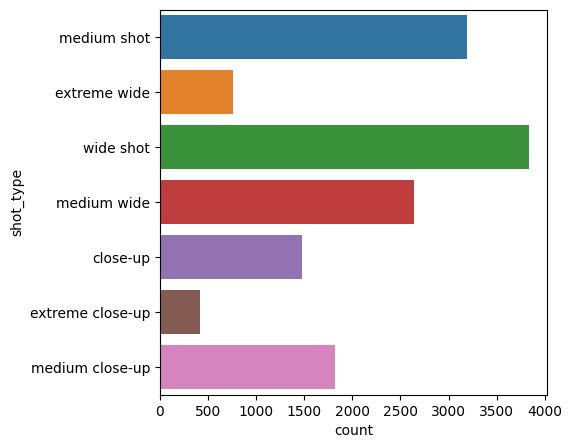

In [ ]:
plot_column('shot_type', shot_type_df.toPandas())

### Removing extreme close-up and extreme wide shots

### Since the data relating to the extreme close up and extreme wide shot classes are much lower in number than for the other classes, we have decided to eliminate them from the dataset.

In [10]:
shot_type_df = shot_type_df.filter(col('shot_type') != 'extreme close-up')
shot_type_df = shot_type_df.filter(col('shot_type') != 'extreme wide')

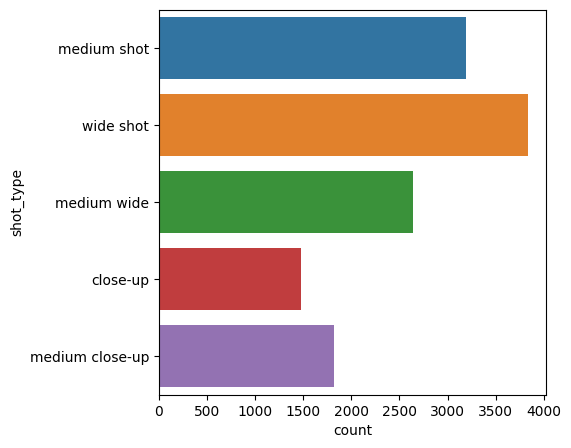

In [ ]:
plot_column('shot_type', shot_type_df.toPandas())

### Udersampling to the class with minimum count

### Looking at the graph above we decided to undersample the classes in order to have enough data and obtain a balance between the classes present. In particular, the data has all been reduced to the close-up level, a class that has 1475 samples.


In [11]:
from pyspark.sql import functions as F
import builtins as p


def create_balanced_shot_df(shot_type_df):
    # get type of shot list
    list_types_of_shot = shot_type_df.select(F.collect_set('shot_type').alias('shot_type')).first()['shot_type']

    # get minimun value
    minsize = p.min([shot_type_df.filter(col("shot_type") == shot_type).count() for shot_type in list_types_of_shot])

    # define en empty df
    emp_RDD = spark.sparkContext.emptyRDD()
    balanced_shot_type_df = spark.createDataFrame(data = emp_RDD, schema = shot_type_df.schema)

    # get randomly the number of samples defined by minsize
    for shot_type in list_types_of_shot:
        balanced_shot_type_df = balanced_shot_type_df.union(shot_type_df.filter(col("shot_type") == shot_type).select("*").orderBy(F.rand(RANDOM_SEED)).limit(minsize))

    return balanced_shot_type_df

balanced_shot_type_df = create_balanced_shot_df(shot_type_df)

### Number of samples for each type of shot after undersampling

In [ ]:
balanced_shot_type_df.groupBy("shot_type").count().show()

+---------------+-----+
|      shot_type|count|
+---------------+-----+
|       close-up| 1475|
|medium close-up| 1475|
|    medium wide| 1475|
|    medium shot| 1475|
|      wide shot| 1475|
+---------------+-----+



## **3.1.2** Shot type dataset creation

### Creating a pandas version of the type of shot dataframe

In [ ]:
balanced_shot_type_df_pandas = balanced_shot_type_df.toPandas()

### Function to associate the shot type with the image

In [ ]:
def get_shot_type(path):
  filename = path.split("/")[-1]
  try:
    return balanced_shot_type_df_pandas[balanced_shot_type_df_pandas['filename'] == filename]['shot_type'].tolist()[0]
  except:
    return None

get_shot_type_udf = udf(get_shot_type, StringType())

### Reading images from the directory into a pyspark dataframe

In [ ]:
shot_type_gallery = spark.read.format("binaryFile") \
  .load(GDRIVE_DATA_DIR) \
  .withColumn("shot_type", get_shot_type_udf(col("path"))) \
  .drop("length", "modificationTime")

### Removing images that do not have a shot type associated with them

In [ ]:
final_shot_type_df = shot_type_gallery.filter(col("shot_type").isNotNull())

In [ ]:
final_shot_type_df.count()

7375


### Saving the balanced dataframe, containing the images in binary format and their associated shot type

In [ ]:
final_shot_type_df.write.parquet(GDRIVE_HOME_DIR + "/Big_Data/shot_type/binaryData.parquet")

## **3.1.3** Shot type data visualization

### Reading the created dataset into a pyspark df

In [ ]:
from pyspark.sql import functions as F
url = GDRIVE_HOME_DIR + "/Big_Data/shot_type/binaryData.parquet"
spark_df = spark.read.parquet(url).select("*").orderBy(F.rand(RANDOM_SEED))

### Function to display movie frames by shot type

In [ ]:
import PIL.Image as Image
import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_shot_type(shot_type, df, shots_number=6):
    rows = df.filter(df.shot_type == shot_type).head(shots_number)

    fig, axarr = plt.subplots(2, shots_number // 2, figsize=(12, 6))
    fig.tight_layout(pad=0.01)

    for i, row in enumerate(rows):
        img = Image.open(io.BytesIO(row.content)).resize([350, 224])
        axarr[i // (shots_number // 2), i % (shots_number // 2)].imshow(img)
        axarr[i // (shots_number // 2), i % (shots_number // 2)].axis('off')
        axarr[i // (shots_number // 2), i % (shots_number // 2)].set_title(row.movie_title, fontsize=10)

    plt.show()

### **Close-up**

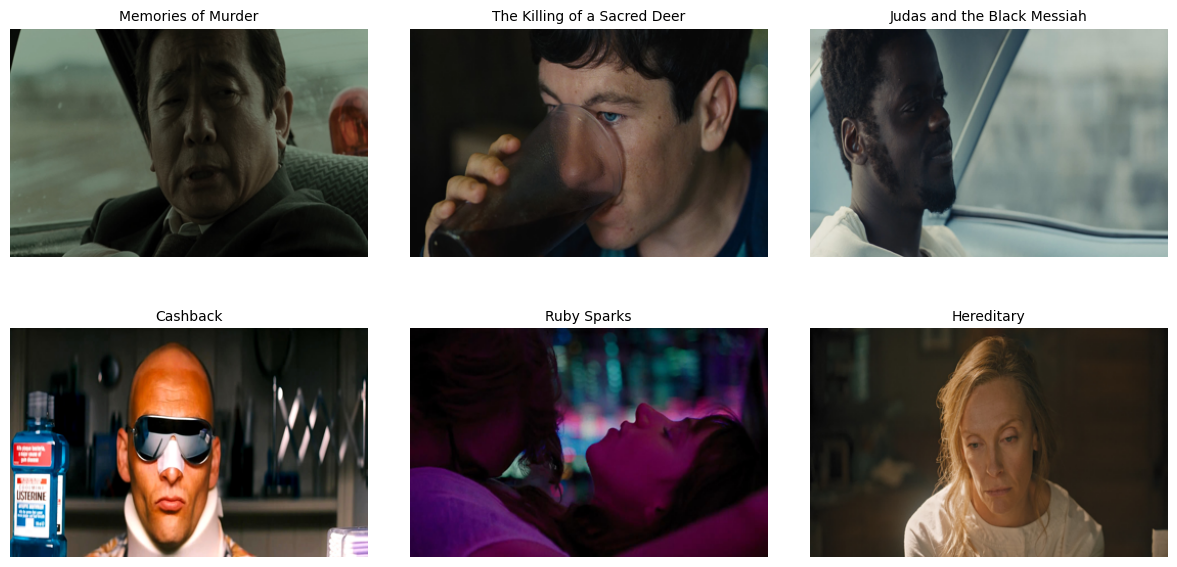

In [ ]:
plot_shot_type("close-up", spark_df)

### **Medium close-up**

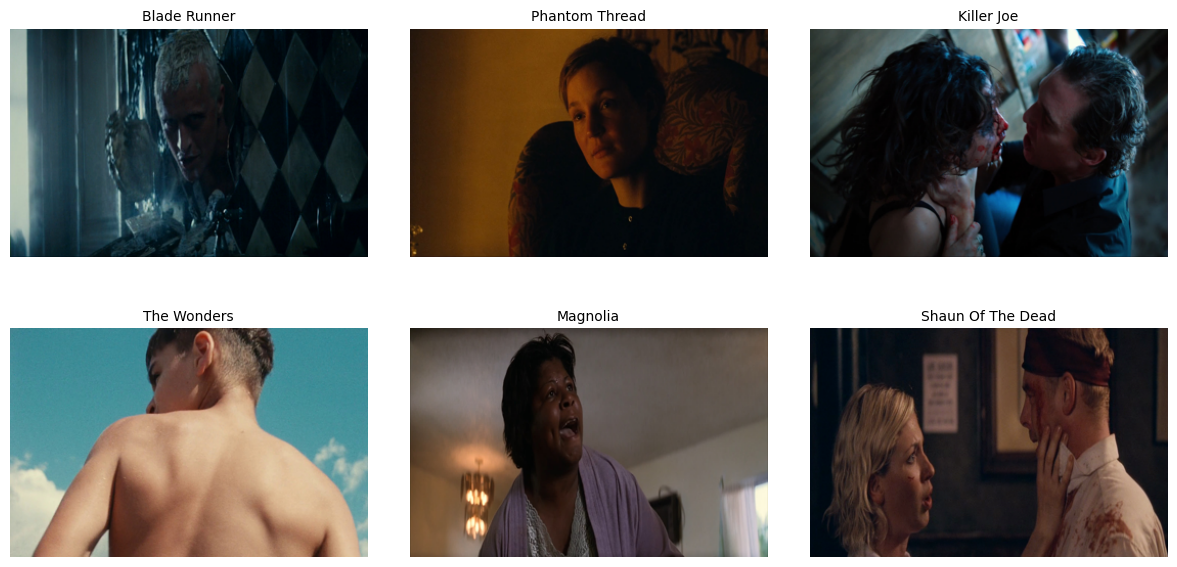

In [ ]:
plot_shot_type("medium close-up", spark_df)

### **Medium shot**

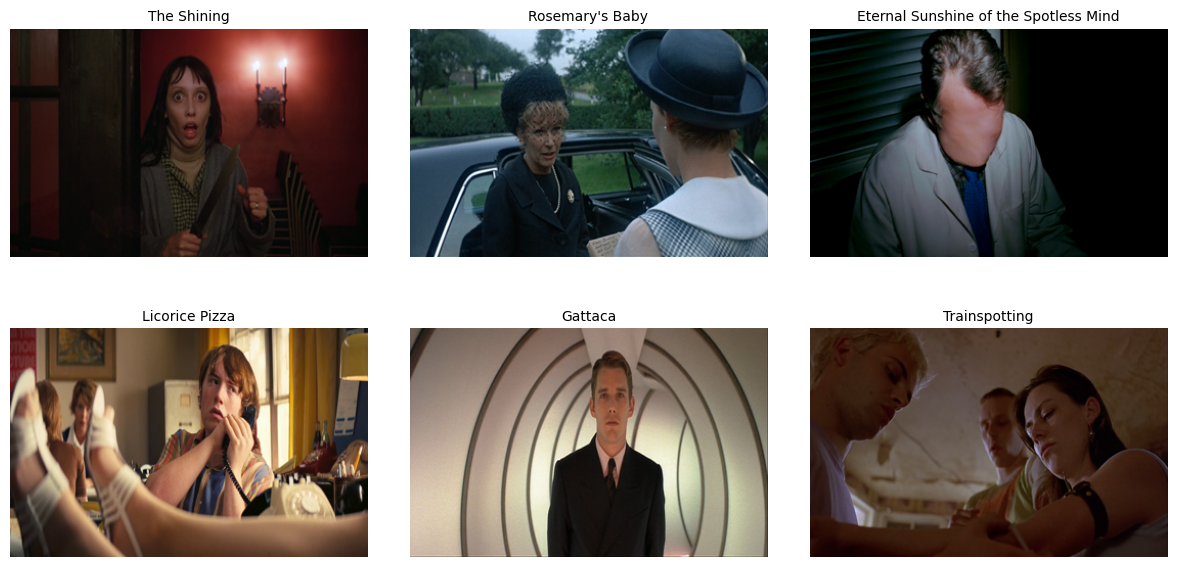

In [ ]:
plot_shot_type("medium shot", spark_df)

### **Medium wide**

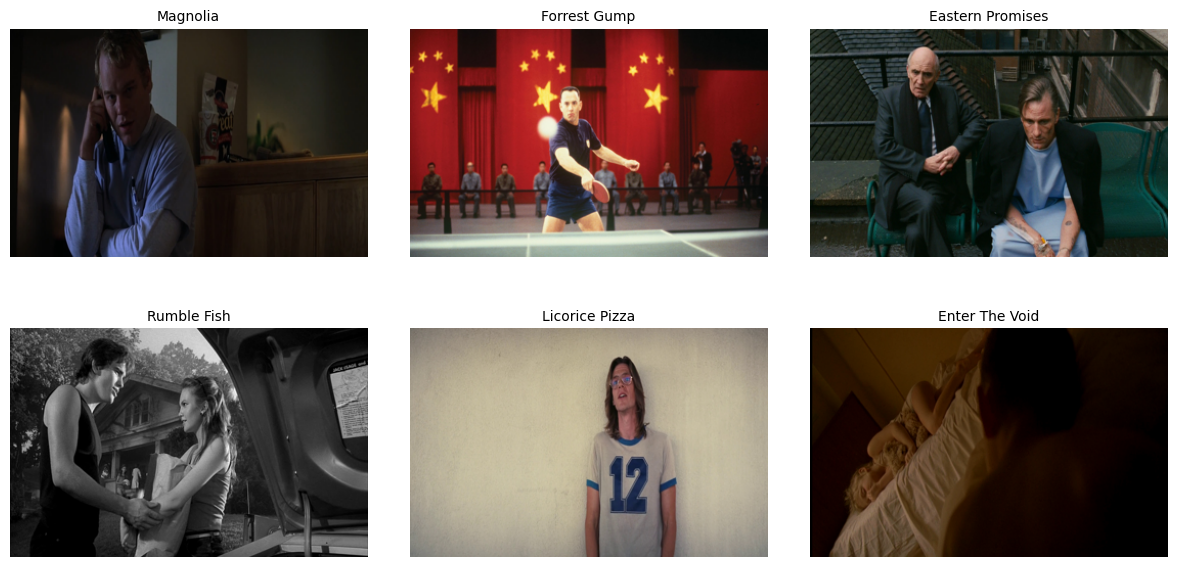

In [ ]:
plot_shot_type("medium wide", spark_df)

### **Wide shot**

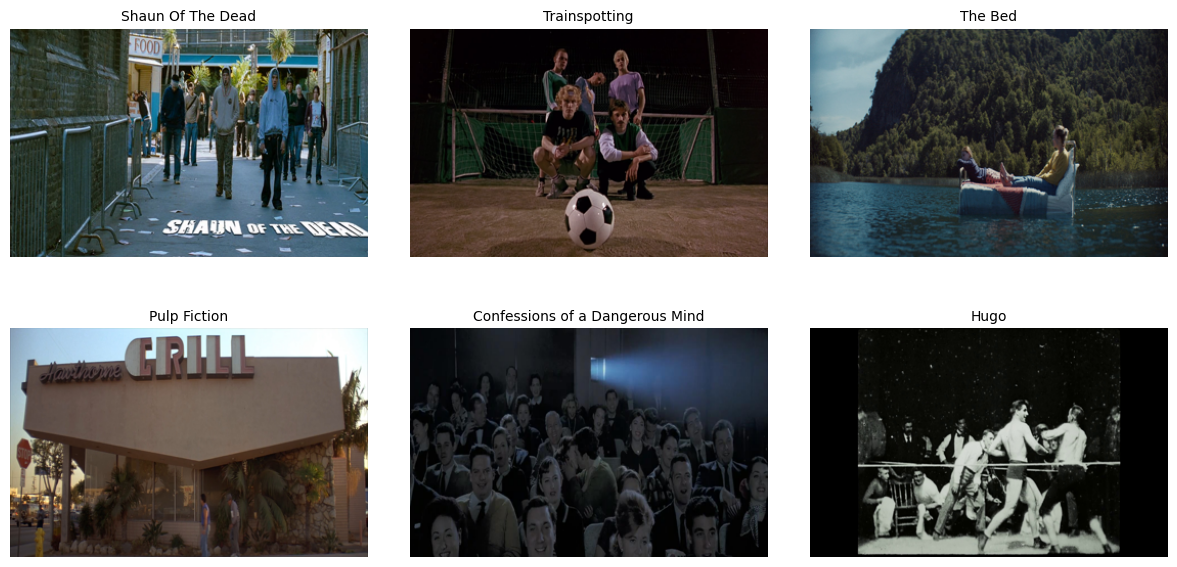

In [ ]:
plot_shot_type("wide shot", spark_df)

## **3.2** Shot ambient
### In this section, the dataset relating to the binary classification task of the ambient of shot is created:

*  ### Exterior
*  ### Interior


## **3.2.1** Dataset balancing

### Get shot ambient data

In [ ]:
ambient_df = shotcafe_df.filter(col("ambient").isNotNull()).drop("shot_type")
ambient_df.printSchema()

root
 |-- image: string (nullable = true)
 |-- movie_title: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- ambient: string (nullable = true)



In [ ]:
ambient_df.groupBy("ambient").count().show()

+--------+-----+
| ambient|count|
+--------+-----+
|    null|  869|
|exterior| 4509|
|interior| 8756|
+--------+-----+



### Removing shots that do not have the ambient tag

In [ ]:
ambient_df = ambient_df.na.drop()

In [ ]:
ambient_df.groupBy("ambient").count().show()

+--------+-----+
| ambient|count|
+--------+-----+
|exterior| 4509|
|interior| 8756|
+--------+-----+



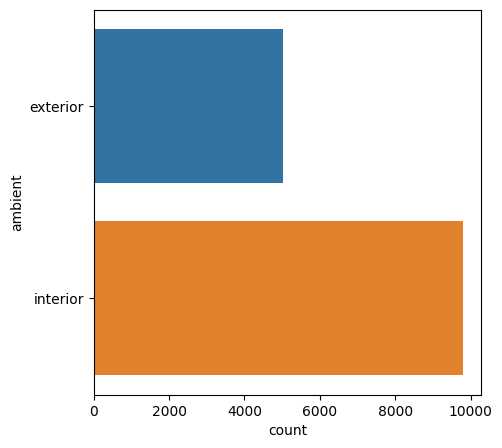

In [ ]:
plot_column('ambient', ambient_df.toPandas())

### Udersampling the class to the same number of samples
### Looking at the graph above we decided to undersample the classes in order to have enough data and obtain a balance between the classes present. In particular we decided to consider 3500 samples for each class.

In [ ]:
from pyspark.sql import functions as F
import builtins as p


def create_balanced_ambient_df(ambient_df):

    shot_ambient_list = ['interior', 'exterior']

    emp_RDD = spark.sparkContext.emptyRDD()
    balanced_shot_ambient_df = spark.createDataFrame(data = emp_RDD, schema = ambient_df.schema)

    for shot_ambient in shot_ambient_list:
        balanced_shot_ambient_df = balanced_shot_ambient_df.union(ambient_df.filter(col("ambient") == shot_ambient).select("*").orderBy(F.rand(RANDOM_SEED)).limit(3500))

    return balanced_shot_ambient_df

balanced_shot_ambient_df = create_balanced_ambient_df(ambient_df)

In [ ]:
balanced_shot_ambient_df.groupBy("ambient").count().show()

+--------+-----+
| ambient|count|
+--------+-----+
|interior| 3500|
|exterior| 3500|
+--------+-----+



## **3.2.2** Shot ambient dataset creation

### Creating a pandas version of the type of shot dataframe

In [ ]:
balanced_shot_ambient_df_pandas = balanced_shot_ambient_df.toPandas()

### Function to associate the shot ambient with the image

In [ ]:
def get_shot_ambient(path):
  filename = path.split("/")[-1]
  try:
    return balanced_shot_ambient_df_pandas[balanced_shot_ambient_df_pandas['filename'] == filename]['ambient'].tolist()[0]
  except:
    return None

get_shot_ambient_udf = udf(get_shot_ambient, StringType())

### Reading images from the directory into a pyspark dataframe

In [ ]:
shot_ambient_gallery = spark.read.format("binaryFile") \
        .load(GDRIVE_DATA_DIR) \
        .withColumn("ambient", get_shot_ambient_udf(col("path"))) \
        .drop("length", "modificationTime")

shot_ambient_gallery.printSchema()

root
 |-- path: string (nullable = true)
 |-- content: binary (nullable = true)
 |-- ambient: string (nullable = true)



In [ ]:
shot_ambient_gallery.groupBy("ambient").count().show()

+--------+-----+
| ambient|count|
+--------+-----+
|    null| 9508|
|exterior| 3500|
|interior| 3500|
+--------+-----+



### Removing images that do not have the ambient tag associated with them

In [ ]:
final_shot_ambient_df = shot_ambient_gallery.filter(col("ambient").isNotNull())
final_shot_ambient_df.count()

7000


### Saving the balanced dataframe, containing the images in binary format and their associated shot ambient tag

In [ ]:
final_shot_ambient_df.write.parquet(GDRIVE_HOME_DIR + "/Big_Data/shot_ambient/shot_ambient_binary_data_7000.parquet")

## **3.2.3** Shot ambient data visualization

### Reading the created dataset into a pyspark df

In [ ]:
from pyspark.sql import functions as F
url = GDRIVE_HOME_DIR + "/Big_Data/shot_ambient/shot_ambient_binary_data.parquet"
ambient_df = spark.read.parquet(url).select("*").orderBy(F.rand())

### Function to display movie frames by shot ambient

In [ ]:
def plot_shot_ambient(shot_ambient, df, shots_number = 6):
    rows = df.filter(df.ambient == shot_ambient).head(shots_number)

    fig, axarr = plt.subplots(2, shots_number // 2, figsize=(12, 6))
    fig.tight_layout(pad=0.1)

    for i, row in enumerate(rows):
        img = Image.open(io.BytesIO(row.content)).resize([350, 224])
        axarr[i // (shots_number // 2), i % (shots_number // 2)].imshow(img)
        axarr[i // (shots_number // 2), i % (shots_number // 2)].axis('off')

    plt.show()

### **Exterior**

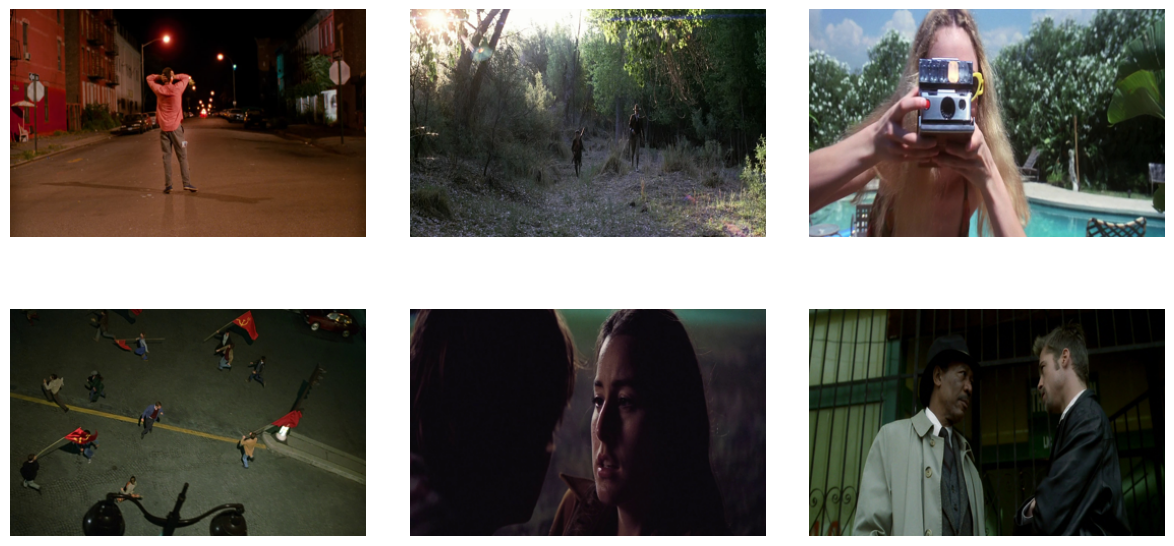

In [ ]:
plot_shot_ambient("exterior", ambient_df)

### **Interior**

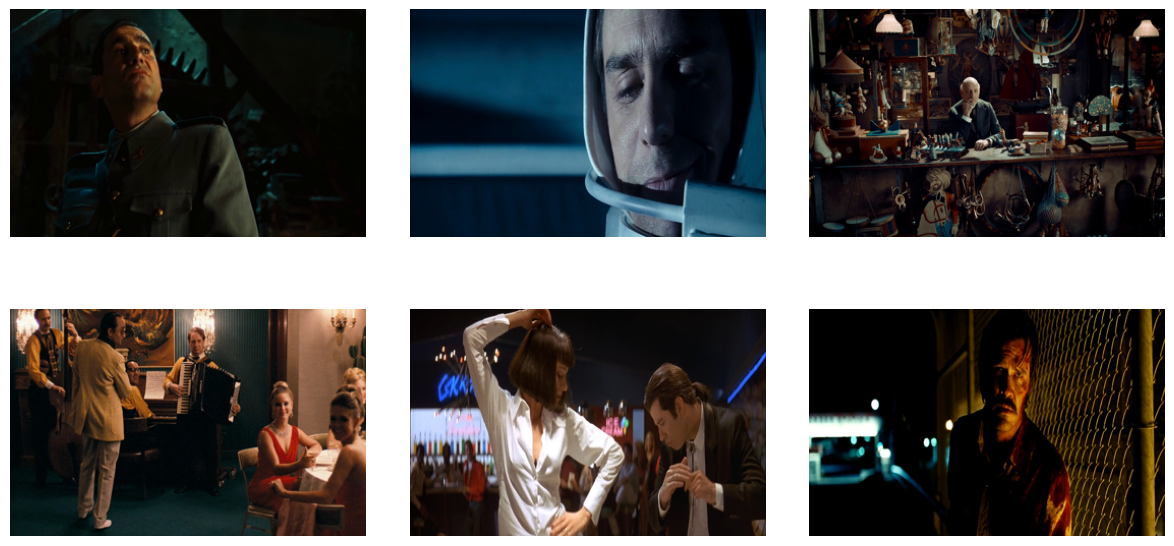

In [ ]:
plot_shot_ambient("interior", ambient_df)

## **3.3** Color clustering

### This section contains the code relating to the creation of datasets for the clustering of the frame color palette
### To carry out clustering based on the color palette we decided to proceed with two different approaches, specifically using the data in two different ways. We created the following data for each image:


*   ### An image with a shape 50 x 50 representing the dominant color palette.

![picture](https://drive.google.com/uc?id=15S_eEhR6f80Ktbmq9ALVJCL1lhcIdZu8)

*   ### The first line of pixels of the image described above expressed in RGB format.


```
# +------------------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------------+--------------+--------------+--------------+------------+------------+------------+------------+------------+------------+------------+------------+
|filename                      |1          |2          |3          |4          |5          |6          |7          |8          |9          |10         |11         |12         |13         |14         |15         |16         |17         |18         |19          |20          |21          |22          |23          |24          |25          |26          |27          |28          |29          |30          |31             |32             |33             |34             |35             |36             |37             |38             |39            |40            |41            |42            |43          |44          |45          |46          |47          |48          |49          |50          |
+------------------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------------+--------------+--------------+--------------+------------+------------+------------+------------+------------+------------+------------+------------+
|the-wonders-2014-281-20165.jpg|[10, 12, 8]|[10, 12, 8]|[10, 12, 8]|[10, 12, 8]|[10, 12, 8]|[10, 12, 8]|[10, 12, 8]|[10, 12, 8]|[10, 12, 8]|[10, 12, 8]|[10, 12, 8]|[10, 12, 8]|[10, 12, 8]|[10, 12, 8]|[10, 12, 8]|[10, 12, 8]|[10, 12, 8]|[10, 12, 8]|[30, 29, 20]|[30, 29, 20]|[30, 29, 20]|[30, 29, 20]|[30, 29, 20]|[30, 29, 20]|[30, 29, 20]|[30, 29, 20]|[30, 29, 20]|[30, 29, 20]|[30, 29, 20]|[30, 29, 20]|[136, 129, 103]|[136, 129, 103]|[136, 129, 103]|[136, 129, 103]|[136, 129, 103]|[136, 129, 103]|[136, 129, 103]|[136, 129, 103]|[115, 101, 67]|[115, 101, 67]|[115, 101, 67]|[115, 101, 67]|[66, 61, 45]|[66, 61, 45]|[66, 61, 45]|[66, 61, 45]|[73, 89, 89]|[73, 89, 89]|[73, 89, 89]|[73, 89, 89]|
+------------------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------------+--------------+--------------+--------------+------------+------------+------------+------------+------------+------------+------------+------------+
```



## **3.3.1** Color palette datasets creation

## Function for displaying and obtaining the palette image of a shot

In [ ]:
from PIL import Image
import pandas as pd
import os
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [ ]:
def plot_palette(clusters, labels, colors, show_flag = False, size=(50, 50)):

    #labels form 0 to no. of clusters
    numLabels = np.arange(0, clusters+1)

    #create frequency count tables
    (hist, _) = np.histogram(labels, bins = numLabels)
    hist = hist.astype("float")
    hist /= hist.sum()

    #descending order sorting as per frequency count
    colors = colors[(-hist).argsort()]
    hist = hist[(-hist).argsort()]

    #creating empty chart
    chart = np.zeros((size[0], size[1], 3), np.uint8)
    start = 0

    #creating color rectangles
    for i in range(clusters):
        end = start + hist[i] * size[1]

        #getting rgb values
        r = colors[i][0]
        g = colors[i][1]
        b = colors[i][2]

        #using cv2.rectangle to plot colors
        cv2.rectangle(chart, (int(start), 0), (int(end), size[0]), (int(r), int(g), int(b)), -1)
        start = end

    if show_flag:
        #display chart
        plt.figure()
        plt.axis("off")
        plt.imshow(chart)
        plt.show()

    return colors, chart

### Function named get_dominant_colors that calculates the dominant colors in an image using the k-means clustering algorithm. Eveery single image is used as a dataset and each data point represents a pixel characterized by an rgb value.
### In the first step the algorithm select 6 (becasuse we wanted to extract six color to create a palette) data points from the dataset to serve as initial centroids for the clusters.Then a distance between each data point (pixel) and the centroids is computeed and each data point is assigned to the cluster with the closest centroid. After the cluster centroids update phase the final centroids will represent the average colors of each cluster, and the RGB values of the centroids will form the color palette. The following shows how the image is represented. The dominant color palette is extracted from this representation.
![picture](https://drive.google.com/uc?id=1-uvxn0uTV4bvowj6q2vnrj0phd32wnlN)

In [ ]:
def get_dominant_colors(image, clusters):
    # read image
    img_src = cv2.imread(image)

    # resize image
    small_img = cv2.resize(img_src, (100, 100))

    # convert to rgb from bgr
    img = cv2.cvtColor(small_img, cv2.COLOR_BGR2RGB)

    # reshaping to a list of pixels
    img = img.reshape((img.shape[0] * img.shape[1], 3))

    # using k-means to cluster pixels
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(img)

    # the cluster centers are our dominant colors.
    colors = kmeans.cluster_centers_

    # save labels
    labels = kmeans.labels_

    return colors.astype(int), labels

### Function that applied to the dataset containing the shots returns for each of these an image depicting the palette of the shot and the first row of this image represented in rgb format.

In [ ]:
def get_color_palette(file_path):

  clusters = 6

  # get the first six dominant color of the ima
  colors, labels = get_dominant_colors(GDRIVE_DATA_DIR + '/' + file_path, clusters)

  # get the palette image
  _, img = plot_palette(clusters, labels , colors)

  split = file_path.split(".")

  # converting the palette img in png format to avoid noise
  if split[-1] != "png": file_path = split[0] + ".png"

  # save the palette image
  Image.fromarray(img).save(GDRIVE_CLUSTER_DATA_DIR + '/' + file_path)

  # taking only first row
  pixel_values = img[0].flatten().tolist()

  # return the first row of the palette image
  return [pixel_values[i:i+3] for i in range(0, len(pixel_values), 3)]

get_palette = udf(get_color_palette, ArrayType(ArrayType(IntegerType())))

### Create the dataset containing the first row of the shot color palette

In [ ]:
# Read filenames of images into a list
file_list = [(filename, ) for filename in os.listdir(GDRIVE_DATA_DIR)]

import random
random.shuffle(file_list)
file_list = file_list[:8_000]

# Define the schema with a single field "filename" of StringType
schema = StructType([StructField("filename", StringType(), True)])

# Create the DataFrame using the data and schema
shot_palette_df = spark.createDataFrame(file_list, schema)

# Apply function to the shots filenames
shot_palette_df = shot_palette_df.withColumn("content", get_palette('filename'))

In [ ]:
shot_palette_df.show(1, truncate = False)

+------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filename                      |content                                                                                                                                                                                                                     

### Split every pixel into a different column

In [ ]:
num_elements = len(shot_palette_df.select("content").first()[0])

shot_palette_df = shot_palette_df.select("filename", *[col("content").getItem(i).alias(f"{i+1}") for i in range(num_elements)])

shot_palette_df.show(1, truncate = False)

+------------------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------------+--------------+--------------+--------------+------------+------------+------------+------------+------------+------------+------------+------------+
|filename                      |1          |2          |3          |4          |5          |6          |7          |8          |9          |10         |11         |12         |13         |14         |15         |16         |17         |18         |19          |20          |21          |22          |23 

## Save the shot palette dataframe

In [ ]:
shot_palette_df.write.mode("overwrite").parquet(GDRIVE_HOME_DIR + "/Big_Data/cluster_colors/K-Means/data/palette_df.parquet")

## **3.3.2** Color palette data visualization

In [ ]:
from matplotlib import gridspec

def visualize_image_3d_with_image(image, chart_size=(1, 1)):
    # Extract RGB values from the image
    pixels = np.array(image).reshape(-1, 3)

    # Set up the figure and gridspec
    fig = plt.figure(figsize=(14, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[chart_size[0], chart_size[1]])
    ax_3d = fig.add_subplot(gs[0], projection='3d')
    ax_img = fig.add_subplot(gs[1])

    # Plot the pixels as a scatter plot in the 3D subplot
    ax_3d.scatter(pixels[:, 0], pixels[:, 1], pixels[:, 2], c=pixels/255.0, s=1)

    # Set the labels and limits for the 3D subplot
    ax_3d.set_xlabel('Red', labelpad=10)
    ax_3d.set_ylabel('Green', labelpad=10)
    ax_3d.set_zlabel('Blue', labelpad=10)
    ax_3d.set_xlim(0, 255)
    ax_3d.set_ylim(0, 255)
    ax_3d.set_zlim(0, 255)

    # Display the original image in the image subplot
    ax_img.imshow(image)
    ax_img.axis('off')

    # Adjust the spacing between subplots
    fig.subplots_adjust(wspace=0.1)

    # Show the plot
    plt.show()

### Show some shots and corresponding palettes extracted with KMeans

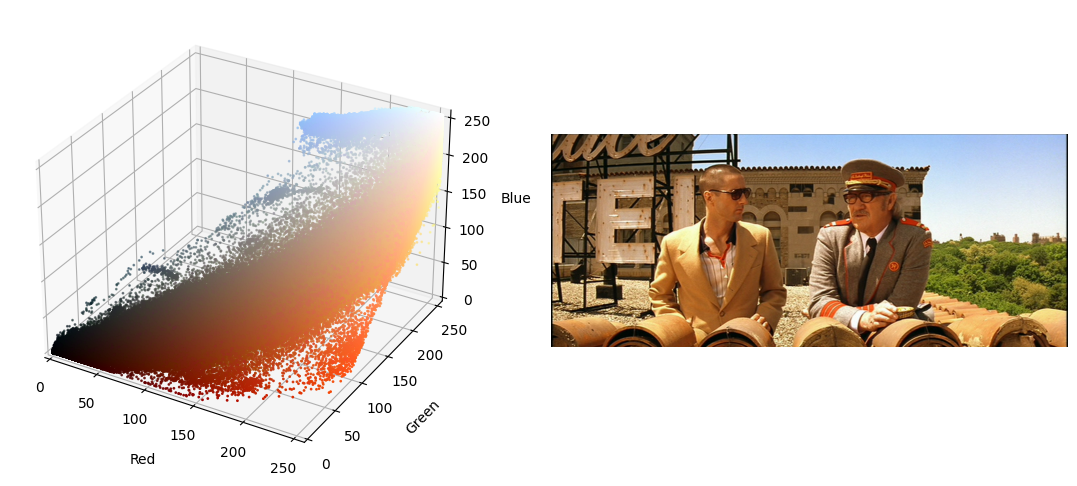

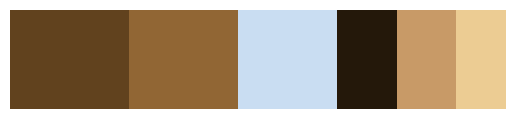

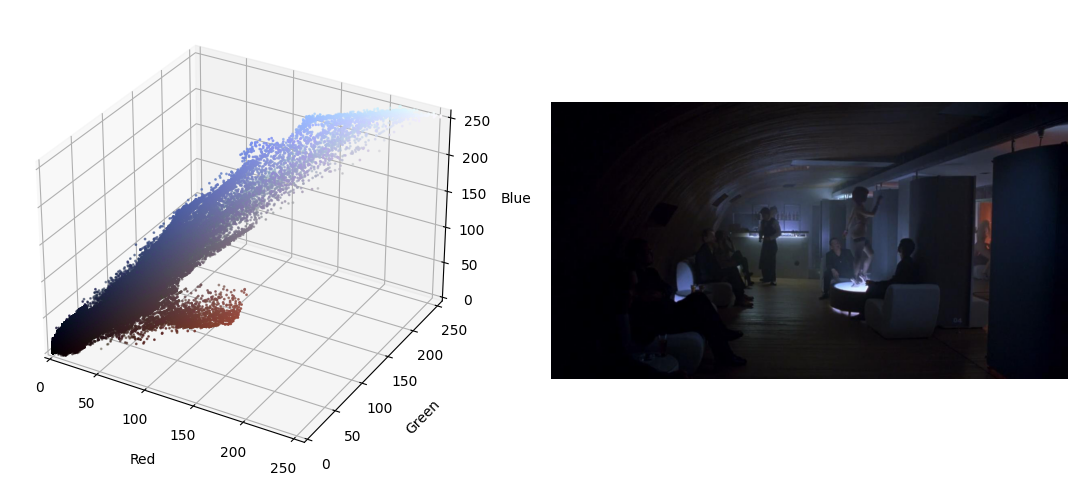

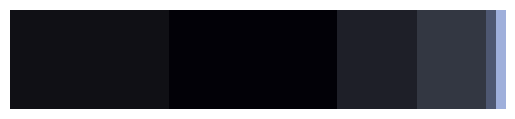

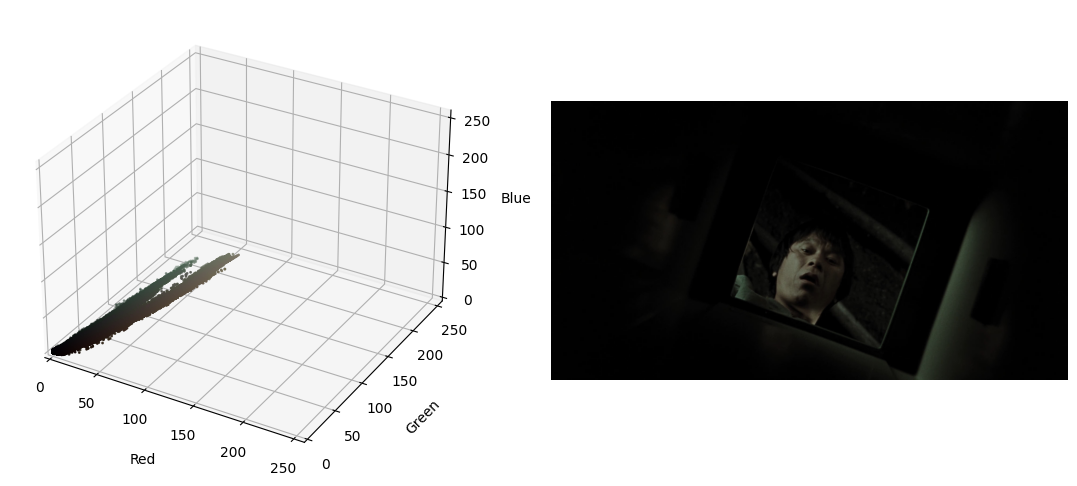

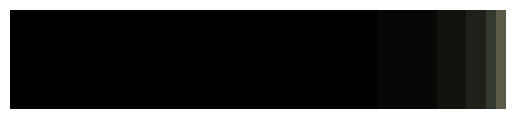

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Read filenames of images into a list
file_list = [filename for filename in os.listdir(GDRIVE_DATA_DIR)]

import random
random.shuffle(file_list)
file_list = file_list[:3]

clusters = 6

for filename in file_list:
  img_path = GDRIVE_DATA_DIR + "/" + filename
  colors, labels = get_dominant_colors(img_path, clusters)
  image = Image.open(img_path)
  visualize_image_3d_with_image(image)
  plot_palette(clusters, labels, colors, True, size=(10, 50))